In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re

import math

import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import MultiLabelBinarizer
multilabel_binarizer = MultiLabelBinarizer()


import nltk, spacy
nlp = spacy.load('en', disable=['parser', 'ner'])
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

def parse(x):
	return datetime.strptime(x, '%Y-%m-%d %H:%M:%S %Z')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
data_df = pd.read_csv("https://storage.googleapis.com/dj-pulsar-examples/dj-dna-news.csv",parse_dates = ['modification_date','publication_date'], date_parser=parse)
print('original size',data_df.shape)
data_df = data_df[data_df['language_code']=='en'].reset_index()

data_df['text'] = data_df['snippet'].astype(str) + ' ' + data_df['body'].astype(str)  #data_df['title'].astype(str) + " " + data_df['snippet'].astype(str) + ' ' + data_df['body'].astype(str)
print('size only english',data_df.shape)
print('rows with no text',data_df[data_df['text'].isna()].shape[0])

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,24,32,33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


original size (42010, 35)
size only english (23891, 37)
rows with no text 0


In [0]:
data_df['subject_codes'] = data_df['subject_codes'].fillna('nocategory')
data_df['subject_codes_list'] = data_df['subject_codes'].str.split(',')  

In [5]:
multilabel_binarizer.fit(data_df['subject_codes_list'])
y = multilabel_binarizer.transform(data_df['subject_codes_list'])
y.shape

label_counts = np.sum(y,axis=0)

print(np.mean(label_counts))
print(np.max(label_counts))
print(np.min(label_counts))

MultiLabelBinarizer(classes=None, sparse_output=False)

(23891, 690)

363.8884057971014
22436
1


690

<Figure size 1440x1080 with 0 Axes>

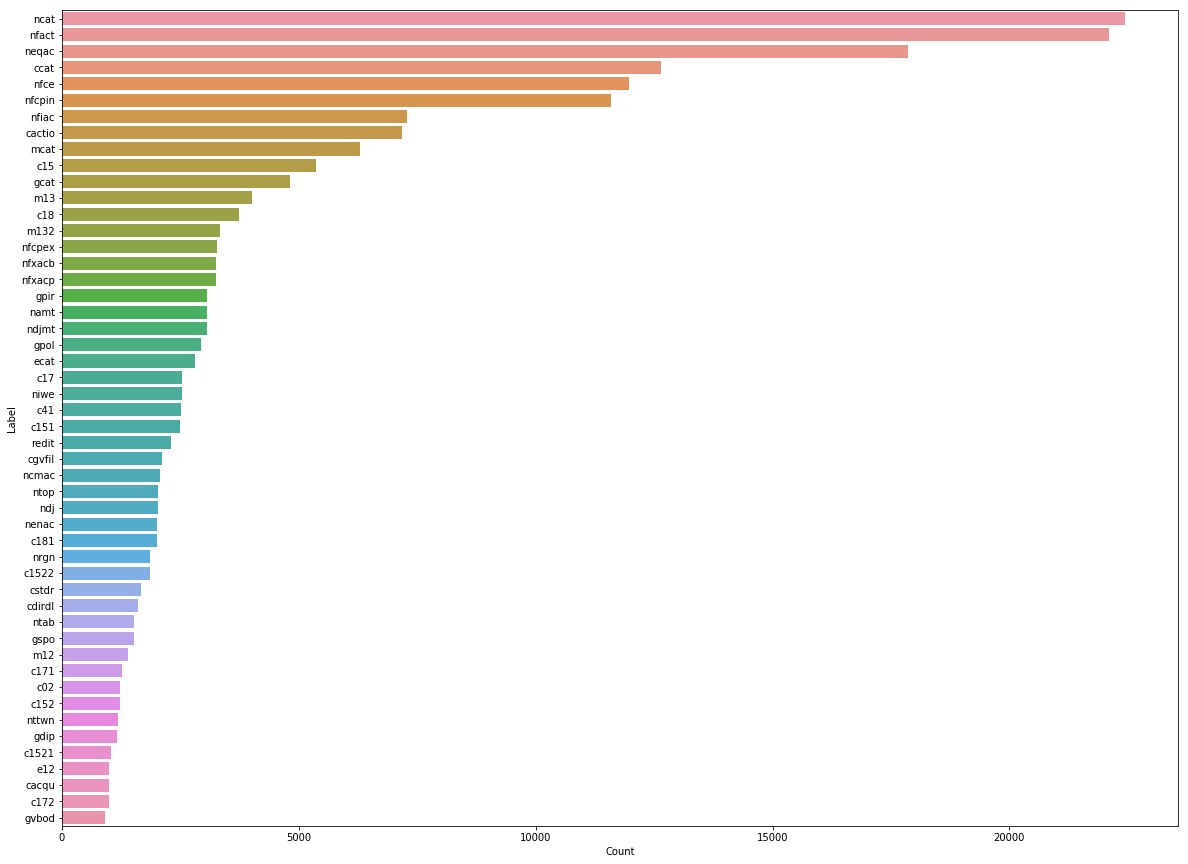

In [7]:
all_labels = sum(data_df['subject_codes_list'],[])
len(set(all_labels))

all_labels = nltk.FreqDist(all_labels)
all_labels_df = pd.DataFrame({'Label': list(all_labels.keys()), 'Count': list(all_labels.values())})

g = all_labels_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(20,15))
ax = sns.barplot(data=g, x= "Count", y = "Label")

plt.show()

In [8]:
nltk.download('stopwords')

from nltk.corpus import stopwords
additional_stops = ['dow','jones','newswires','news','wsj','com','www','http']
stop_words = set(stopwords.words('english')+additional_stops)

#performs slightly better without lemmatization
'''nlp = spacy.load('en', disable=['parser', 'ner'])
def lemmatize(text):
    return [token.lemma_ for token in nlp(text)]'''
  
def clean_text(text):
    text = re.sub("\'", "", text)
    #text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', ' ', text)
    text = re.sub("[^a-z]"," ",text.lower())
    #text = re.sub(r'(.)\1+', r'\1\1', text)
    text = ' '.join([w for w in text.split() if not w in stop_words])
    #text = ' '.join(lemmatize(text))
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

"nlp = spacy.load('en', disable=['parser', 'ner'])\ndef lemmatize(text):\n    return [token.lemma_ for token in nlp(text)]"

In [0]:
data_df['text'].head().apply(lambda x: clean_text(x))

0    global shortage zinc galvanizing investors pri...
1    interview bruce geller ceo dalton greiner hart...
2    housing market finally advancing walk inching ...
3    trillion annuity industrys latest golden child...
4    month ago column weighed positive story armstr...
Name: text, dtype: object

In [0]:
data_df['clean_text'] = data_df['text'].apply(lambda x: clean_text(x))

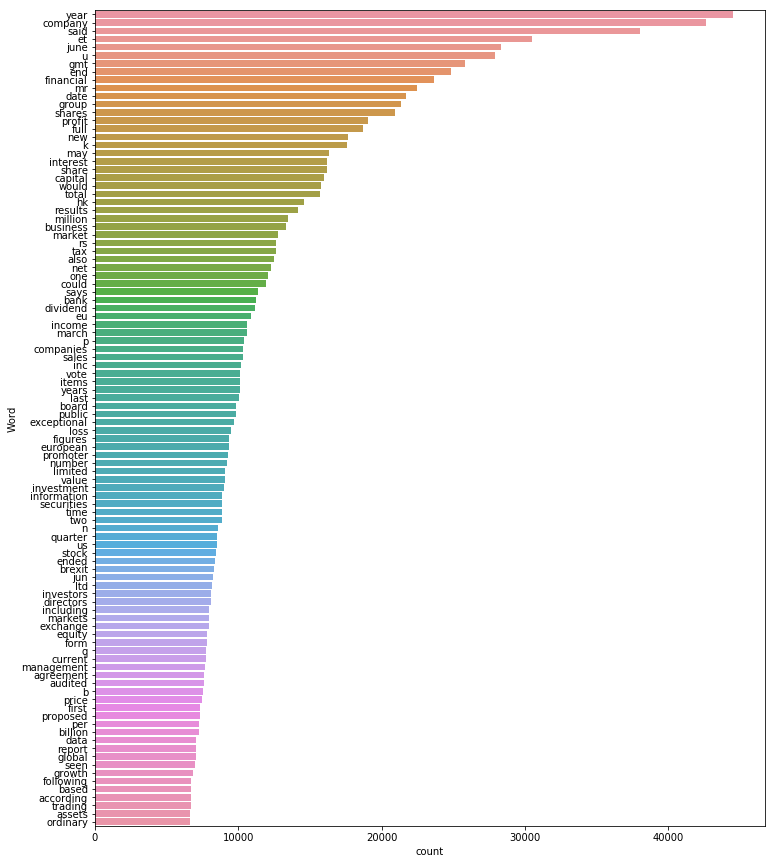

In [10]:
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = nltk.FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(12,15))
  ax = sns.barplot(data=d, x= "count", y = "word")
  plt.show()
  
freq_words(data_df['clean_text'], 100)

In [0]:
#results in too many entries
"""from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(data_df[['clean_text']].values, y)
X_res = X_res.reshape(X_res.shape[0],)

#del data_df
X_res.shape,y_res.shape"""

"from imblearn.over_sampling import RandomOverSampler\n\nros = RandomOverSampler(random_state=42)\nX_res, y_res = ros.fit_resample(data_df[['clean_text']].values, y)\nX_res = X_res.reshape(X_res.shape[0],)\n\n#del data_df\nX_res.shape,y_res.shape"

In [0]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [0]:
xtrain, xval, ytrain, yval = train_test_split(data_df['clean_text'], y, test_size=0.2, random_state=9)

In [0]:
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [0]:
#not enough samples of minority classes
"""from imblearn.over_sampling import SVMSMOTE
sm = SVMSMOTE('auto',random_state=777, k_neighbors=4,m_neighbors=4)
sm_xtrain_tfidf, sm_train_y = sm.fit_sample(xtrain_tfidf, ytrain)
sm_train_y.shape"""

(19112, 86)

In [0]:
from sklearn import naive_bayes, metrics, svm
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.metrics import f1_score
from sklearn.metrics import classification_report


In [0]:
padding_print = "\n \n ###########################################################\n \n"

n_estimators = 10
models = {
          "bayes":{"model":naive_bayes.MultinomialNB()}
          ,"lr":{"model":LogisticRegression()}
          #,"svm":{"model":BaggingClassifier(svm.SVC(kernel='linear', probability=True, class_weight='balanced'), max_samples=1.0 / n_estimators, n_estimators=n_estimators)}
         }
          
results_df = pd.DataFrame(columns = ['model','f1'])

for m in models.keys():
  models[m]['clf'] = OneVsRestClassifier(models[m]['model'])
  models[m]['clf'].fit(xtrain_tfidf, ytrain)
  
  y_pred_prob = models[m]['clf'].predict_proba(xval_tfidf)
  models[m]['y_pred'] = (y_pred_prob >= .3).astype(int)
  models[m]['f1'] = f1_score(yval, models[m]['y_pred'], average="micro")
  print(padding_print,m,' f1: ',models[m]['f1'],padding_print)
  results_df = results_df.append({"model":m,'f1':models[m]['f1']}, ignore_index=True)
  
results_df

OneVsRestClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                            fit_prior=True),
                    n_jobs=None)


 
 ###########################################################
 
 bayes  f1:  0.7505294904646365 
 
 ###########################################################
 



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)


 
 ###########################################################
 
 lr  f1:  0.9372877143567226 
 
 ###########################################################
 



,model,f1
0,bayes,0.750529
1,lr,0.937288


In [0]:
print(classification_report(yval, models['bayes']['y_pred']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1008
           1       0.39      0.83      0.53      1049
           2       0.25      0.75      0.38      1040
           3       0.25      0.82      0.38      1017
           4       0.28      0.73      0.41       983
           5       0.81      0.86      0.84      1042
           6       0.33      0.69      0.45      1012
           7       0.43      1.00      0.60      1010
           8       0.88      0.82      0.85      1040
           9       0.32      0.74      0.45      1015
          10       0.34      0.66      0.45      1031
          11       0.77      1.00      0.87      1003
          12       0.78      0.95      0.86      1034
          13       0.85      0.98      0.91       992
          14       0.80      0.93      0.86      1017
          15       0.77      1.00      0.87      1011
          16       0.92      0.93      0.93      1002
          17       0.50    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [0]:
print(classification_report(yval, models['lr']['y_pred']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1008
           1       0.94      0.88      0.91      1049
           2       0.88      0.83      0.86      1040
           3       0.92      0.82      0.86      1017
           4       0.80      0.85      0.82       983
           5       0.96      0.86      0.91      1042
           6       0.66      0.69      0.68      1012
           7       0.95      1.00      0.97      1010
           8       0.94      0.82      0.88      1040
           9       0.77      0.73      0.75      1015
          10       0.92      0.75      0.82      1031
          11       0.98      1.00      0.99      1003
          12       0.93      0.95      0.94      1034
          13       0.95      0.98      0.97       992
          14       0.91      0.96      0.94      1017
          15       0.94      1.00      0.97      1011
          16       0.98      0.93      0.96      1002
          17       0.92    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [0]:
def infer_tags(q):
    q = clean_text(q)
    q_vec = tfidf_vectorizer.transform([q])
    q_pred = clf.predict(q_vec)
    return multilabel_binarizer.inverse_transform(q_pred)

for i in range(5):
    k = xval.sample(1).index[0]
    pred_subjs = sorted(set(infer_tags(xval[k])))
    actu_subjs = sorted(set(data_df['subject_codes_list'][k]))
    print("Movie: ", data_df['title'][k], "\nPredicted subjs: ", pred_subjs), print("Actual subjs: ",actu_subjs, "\n","\n ##################################################################################################################")